# Acknowledgements and Disclaimers
This borrows heavily from scaffolding code seen in https://github.com/jonfroehlich/CSE590Sp2018.

# Data importation and Setup

In [137]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 
import random
from scipy.spatial import distance
from random import randint # need this for some setup functions
from sklearn import svm # need this for svm
import statistics as stats # need this for some features for svm

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [138]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            #print(trial.gestureName + str(trial.trialNum))
            trial.accel.pad_with_zeros(maxArrayLength + 1)
            trial.gyro.pad_with_zeros(maxArrayLength + 1)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [139]:
# Load the data

# Professor Data
logPath = './JonGestureLogs'
profGestureToTrials = parse_and_create_gesture_trials(logPath)

# My data
myLogPath = './ApurvGestureLogs'
myGestureToTrials = parse_and_create_gesture_trials(myLogPath)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 110 csv files in ./ApurvGestureLogs
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Your Custom Gesture'
Max trial len

In [140]:
# Future things to think about:
#  - What kind of filtering might be useful?
#  - What kind of signal transforms? (e.g., ffts)
#  - Is there value in exploring both the accel data AND the gyro data? 
#  - What is the simplest way we can compare two signals? (scroll down and look for distance.euclidean)?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)

# Visualizations

## My Functions

In [141]:
def visualizeRawData(mapGestureToTrials):

    # Now let's plot all of the accel signals! :)

    # We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
    # and a column for each signal type, so 8 columns (one for x, y, z, and mag) and then repeated for gyroscope
    fig, axes = plt.subplots(len(mapGestureToTrials), 8, figsize=(20, 3 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)

    index = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        trialNum = 1
        for trial in gestureTrials:
            axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][4].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][5].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][6].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
            axes[index][7].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
            trialNum = trialNum + 1

        axes[index][0].set(xlabel='Samples', ylabel="Accel (m/s^2)", title=gestureName + " (Accel X)")    
        axes[index][0].legend()

        axes[index][1].set(xlabel='Samples', ylabel="Accel (m/s^2)", title=gestureName + " (Accel Y)")
        axes[index][1].legend()

        axes[index][2].set(xlabel='Samples', ylabel="Accel (m/s^2)", title=gestureName + " (Accel Z)")
        axes[index][2].legend()

        axes[index][3].set(xlabel='Samples', ylabel="Accel (m/s^2)", title=gestureName + " (Accel Mag)")
        axes[index][3].legend()

        axes[index][4].set(xlabel='Samples', ylabel="Accel (rad/s)", title=gestureName + " (Gyro X)")
        axes[index][4].legend()

        axes[index][5].set(xlabel='Samples', ylabel="Accel (rad/s)", title=gestureName + " (Gyro Y)")
        axes[index][5].legend()

        axes[index][6].set(xlabel='Samples', ylabel="Accel (rad/s)", title=gestureName + " (Gyro Z)")
        axes[index][6].legend()

        axes[index][7].set(xlabel='Samples', ylabel="Accel (rad/s)", title=gestureName + " (Gyro Mag)")
        axes[index][7].legend()

        index = index + 1

        
def frequencyAnalysis(mapGestureToTrials):
    samplingRateInSecs = 50 # android sensor is once every 20,000 microseconds (or once every 0.02 seconds or 50Hz) ?? how to do based on time ??
    NFFTtestVal = 64

    signalTypes = 2 # accel & gyro
    typesOfGraphs = 3 # mag, spectral analysis, spectogram 

    # spectral analysis - first trial spectral analysis and spectogram for accel mag and gyro mag
    fig, axes = plt.subplots(len(mapGestureToTrials), signalTypes * typesOfGraphs, figsize=(5 * signalTypes * typesOfGraphs, 10 * len(mapGestureToTrials)))
    fig.subplots_adjust(hspace=0.5)

    # loop over all gestures
    index = 0
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]

        # pick first trial for each gesture
        trial = gestureTrials[0]

        # accel mag
        axes[index][0].plot(trial.accel.mag, alpha=0.7, label="Trial 1")   
        axes[index][0].set(xlabel='Samples', ylabel="Accel (m/s^2)", title = gestureName + " (Accel Mag)")
        axes[index][0].legend()

        # accel spectral analysis
        powerSpectrum, powerFreq = axes[index][1].psd(trial.accel.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, label="Trial 1")
        axes[index][1].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title="Spectral Analysis Accel ({})".format(gestureName))
        axes[index][1].legend()

        # accel spectogram
        axes[index][2].specgram(trial.accel.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, noverlap=0)
        axes[index][2].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title='FFT of Accel ({})'.format(gestureName))

        # gyro mag
        axes[index][3].plot(trial.gyro.mag, alpha=0.7, label="Trial 1")   
        axes[index][3].set(xlabel='Samples', ylabel="Accel (rad/s)", title = gestureName + " (Gyro Mag)")
        axes[index][3].legend()

        # gyro spectral analysis
        powerSpectrum, powerFreq = axes[index][4].psd(trial.gyro.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, label="Trial 1")
        axes[index][4].set(title="Spectral Analysis Gyro ({})".format(gestureName))
        axes[index][4].legend()
        # gyro spectogram
        axes[index][5].specgram(trial.gyro.mag, NFFT=NFFTtestVal, Fs=samplingRateInSecs, noverlap=0)
        axes[index][5].set(xlabel='Time', ylabel="Frequency (Spectral Energy)", title='FFT Of Gyro ({})'.format(gestureName))

        index = index + 1
      

## Professor data visualization (including gyro data)

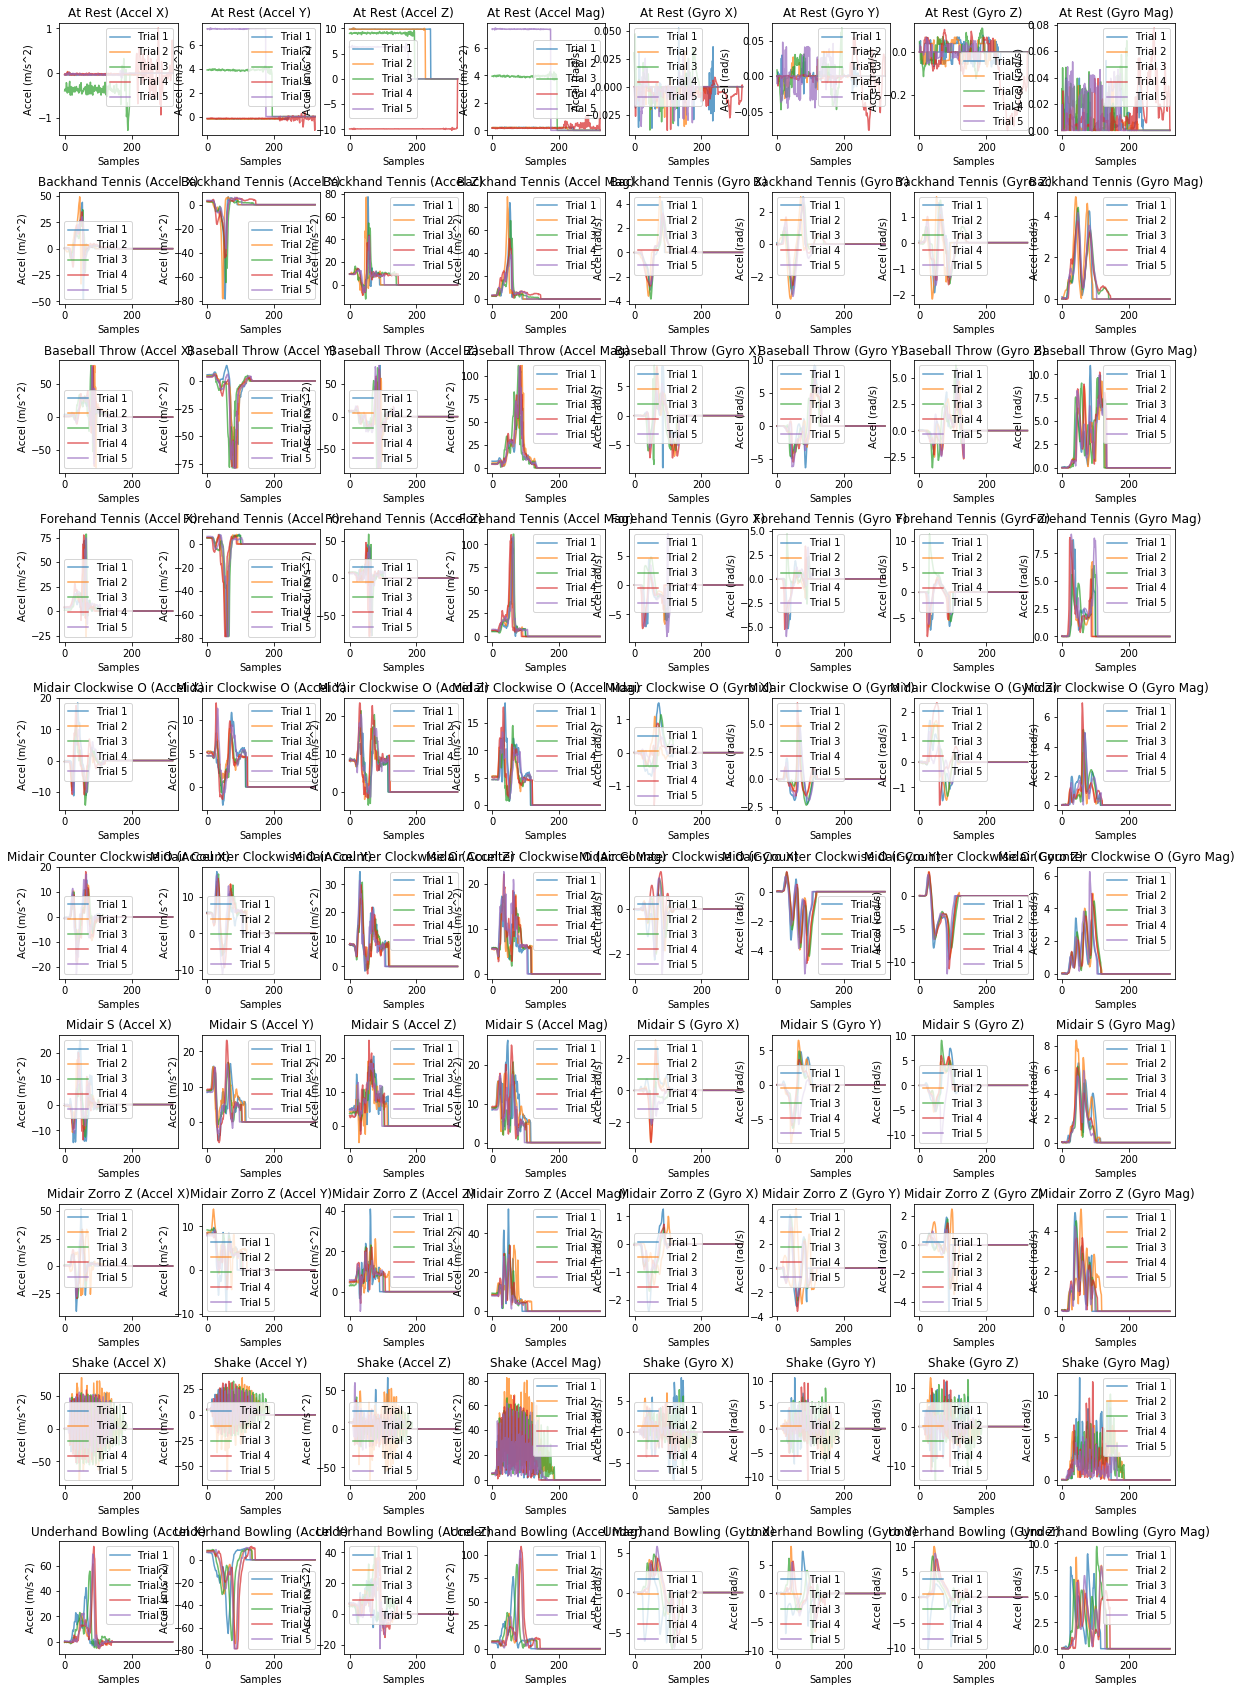

In [142]:
visualizeRawData(profGestureToTrials)

## Professor data frequency analysis

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


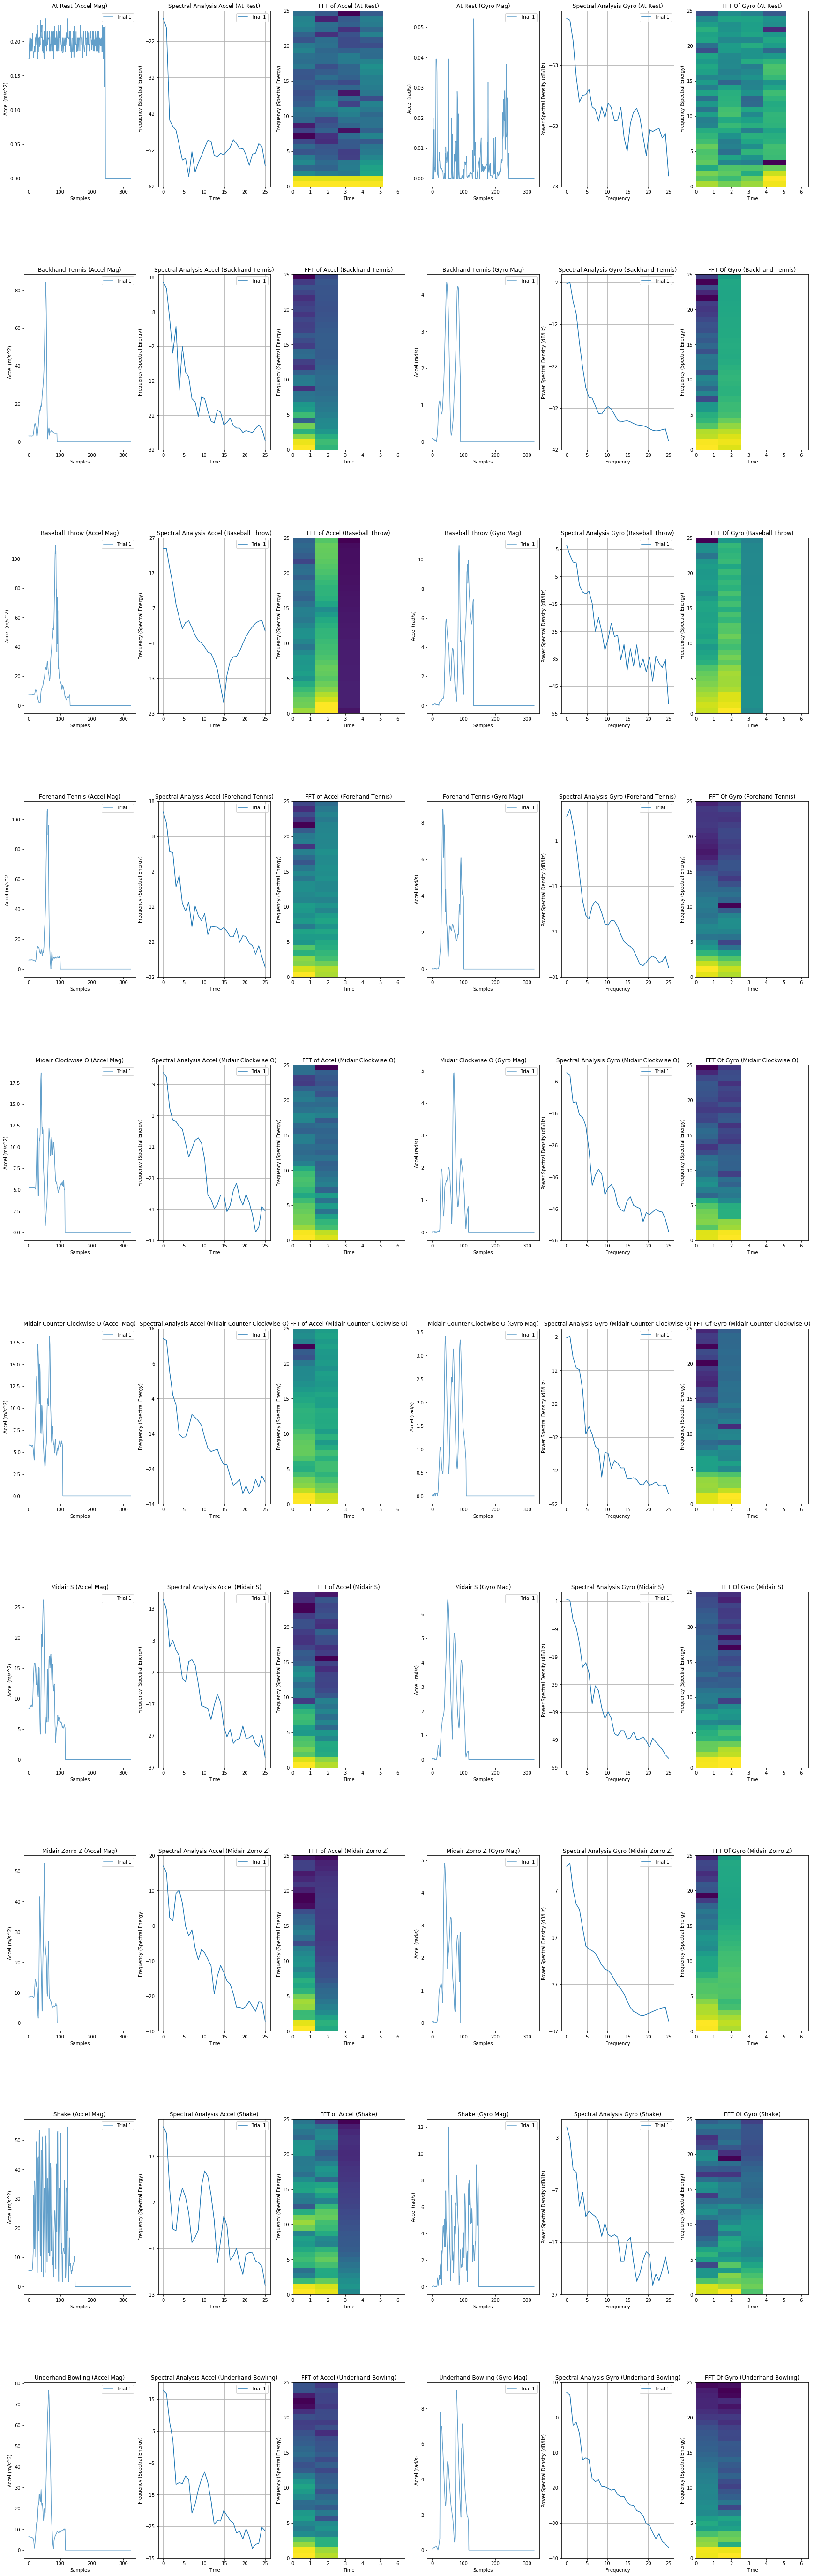

In [143]:
frequencyAnalysis(profGestureToTrials)

## My data visualization (including gyro data)

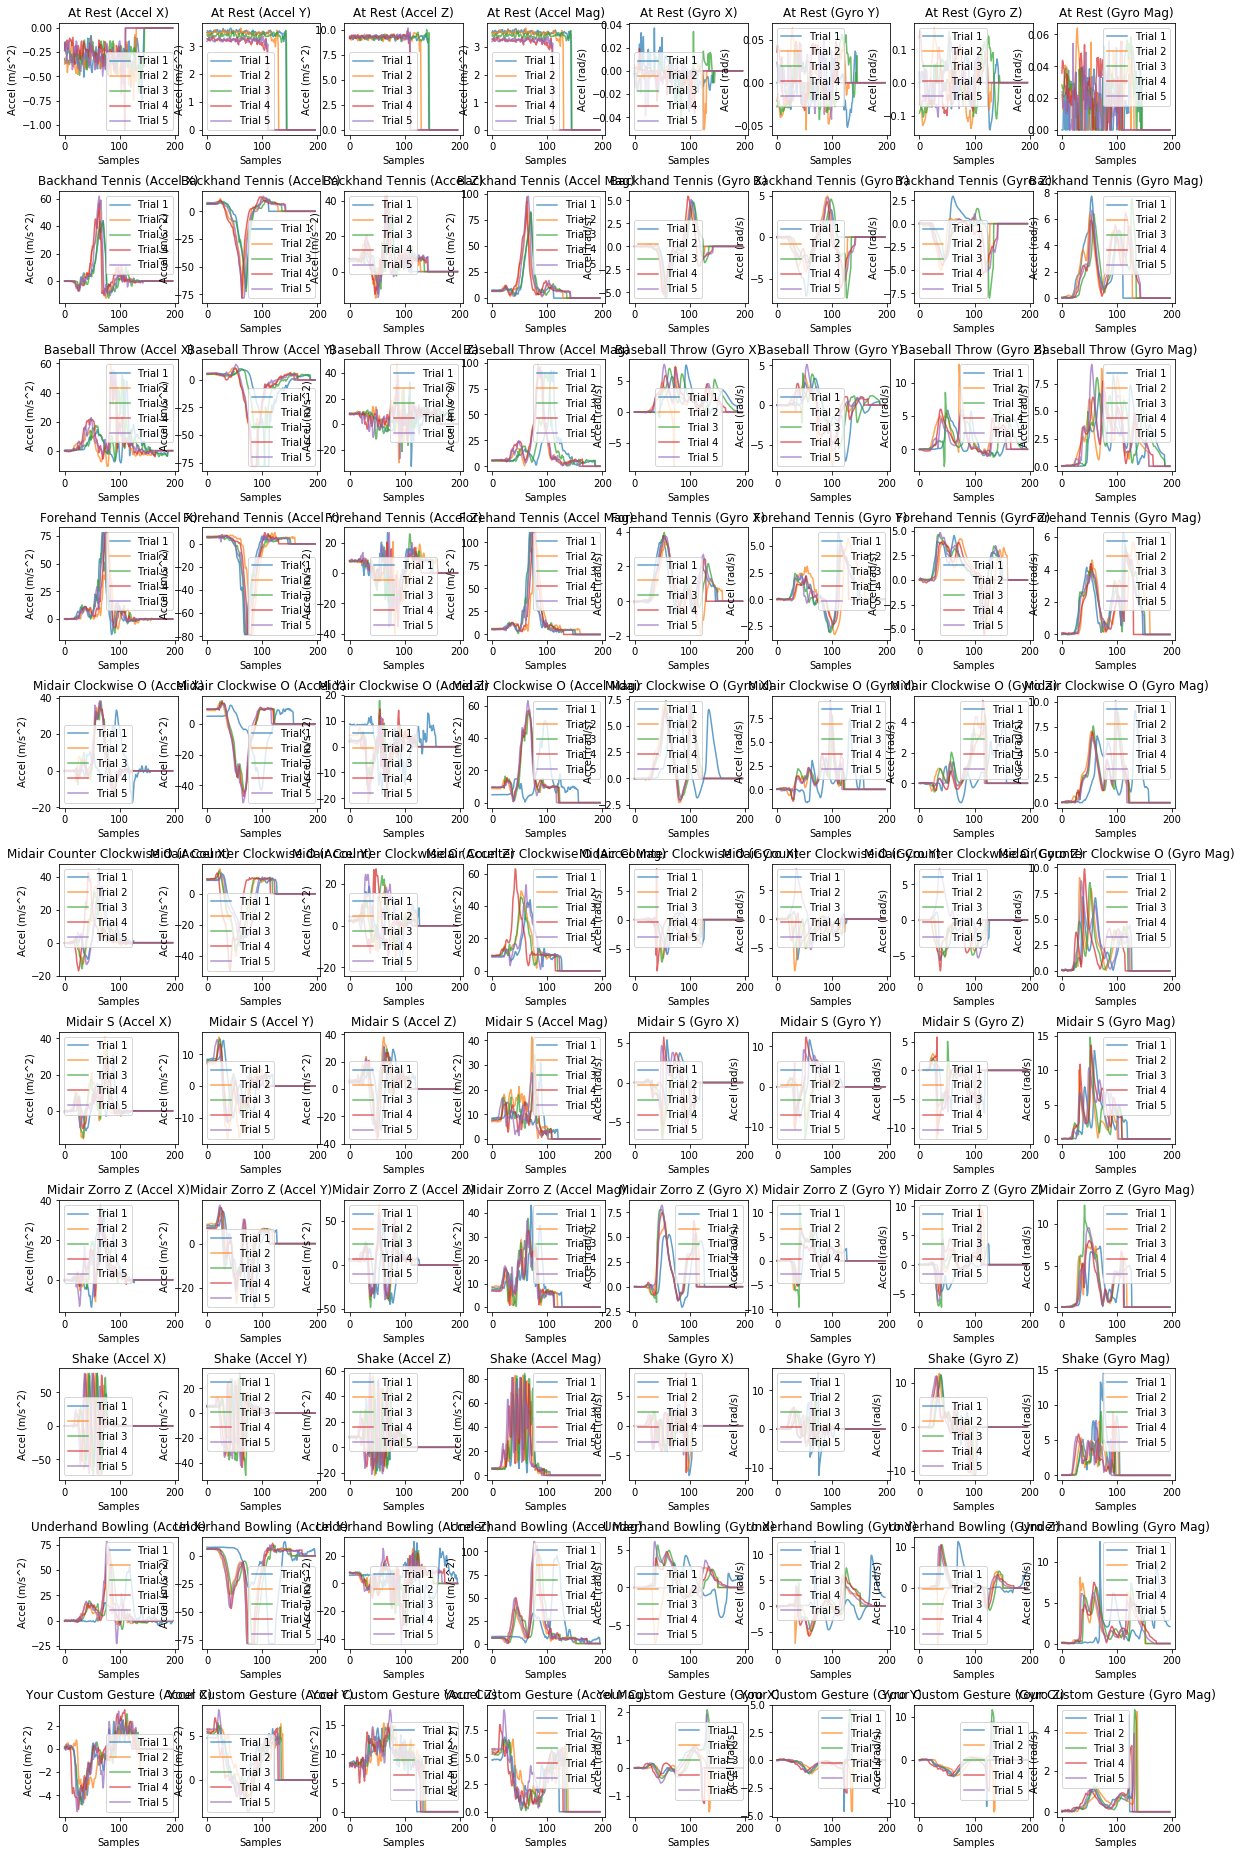

In [144]:
visualizeRawData(myGestureToTrials)

## My data frequency analysis

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


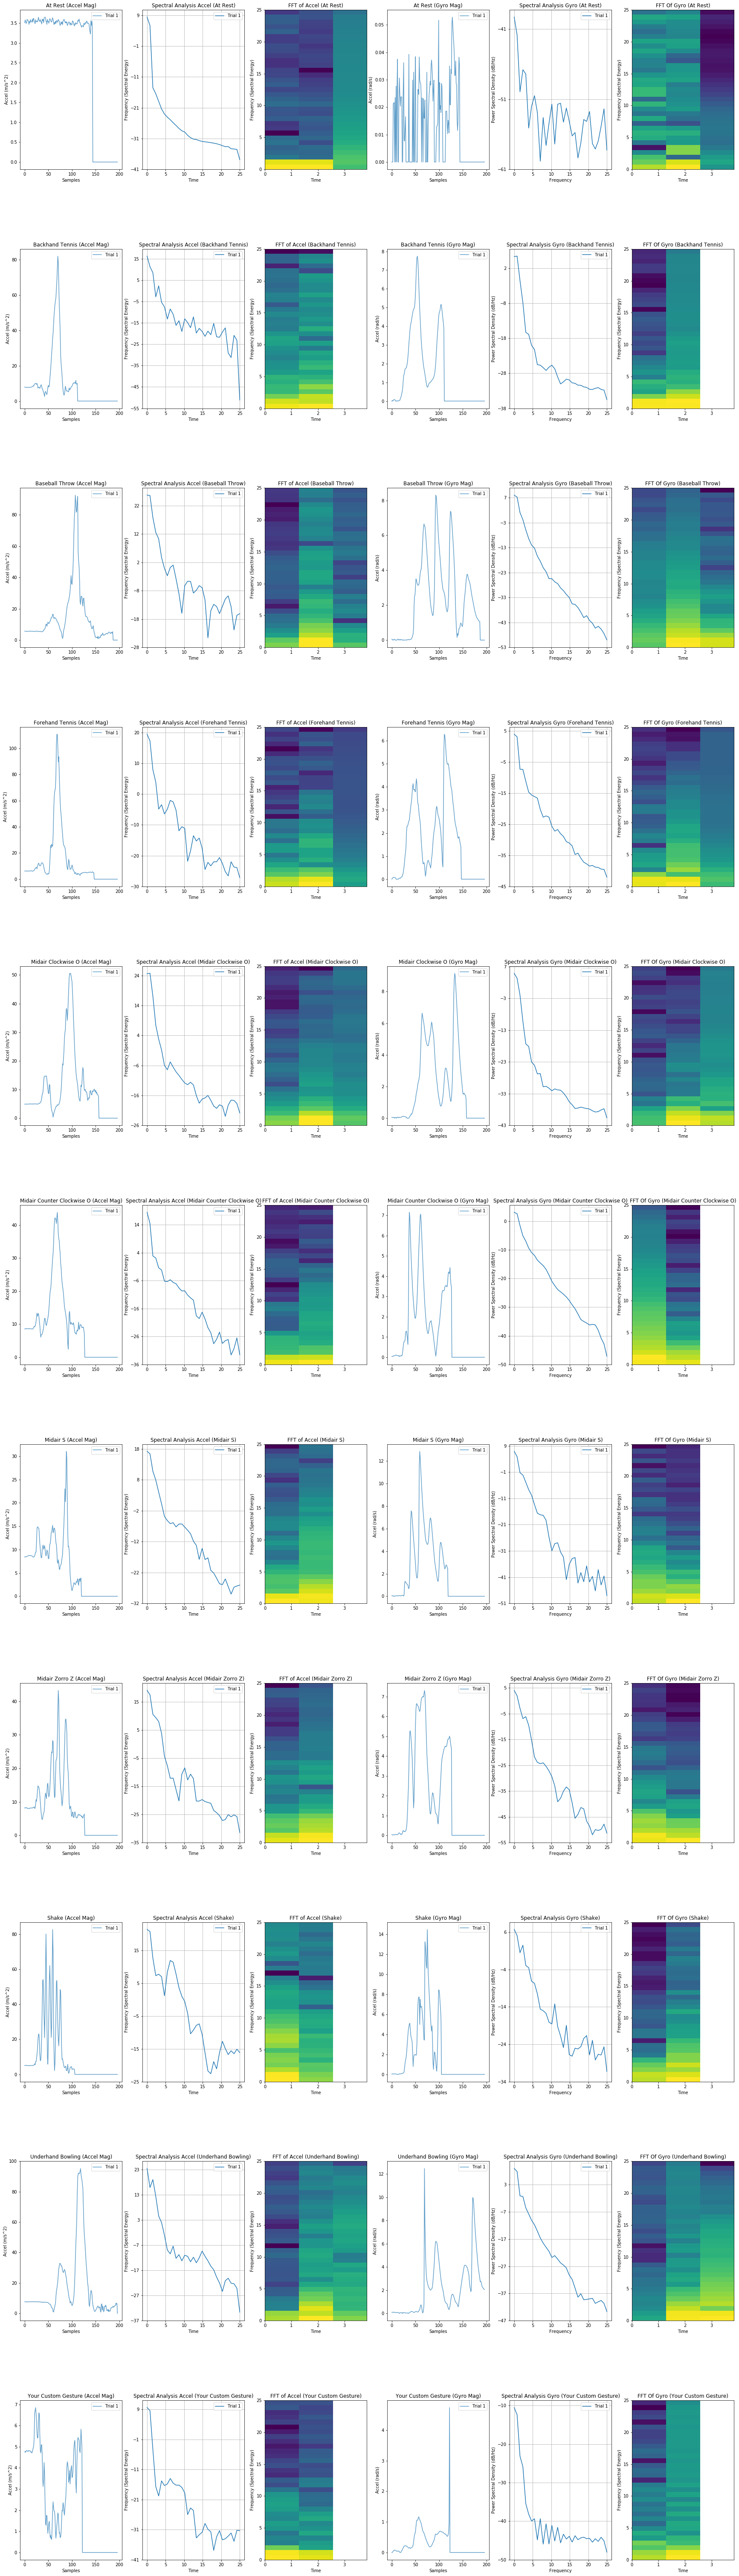

In [145]:
frequencyAnalysis(myGestureToTrials)

## Graphing features for ideas

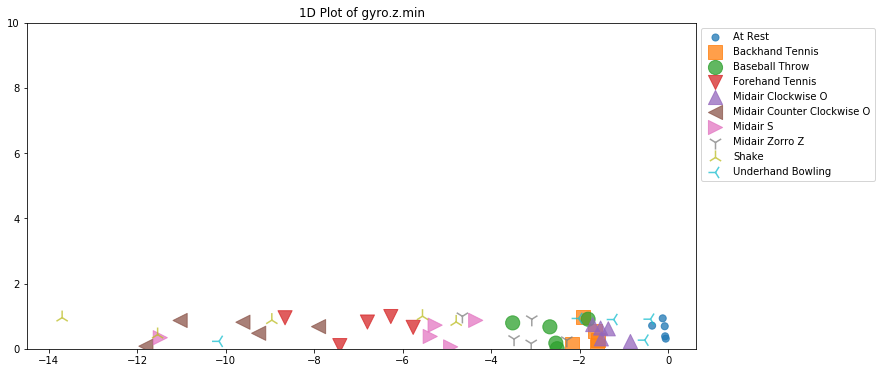

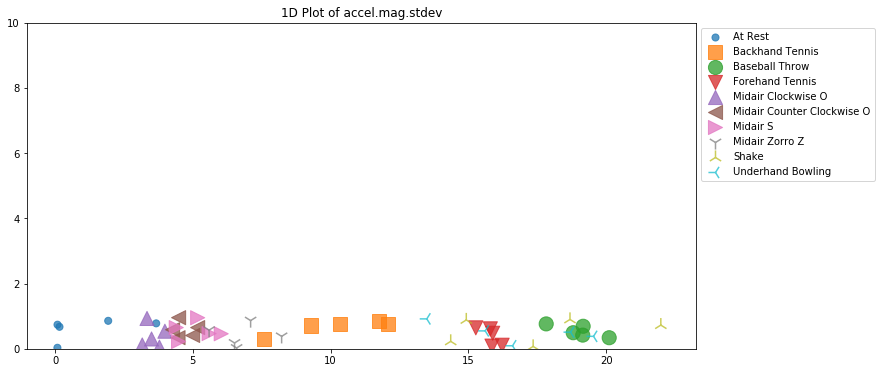

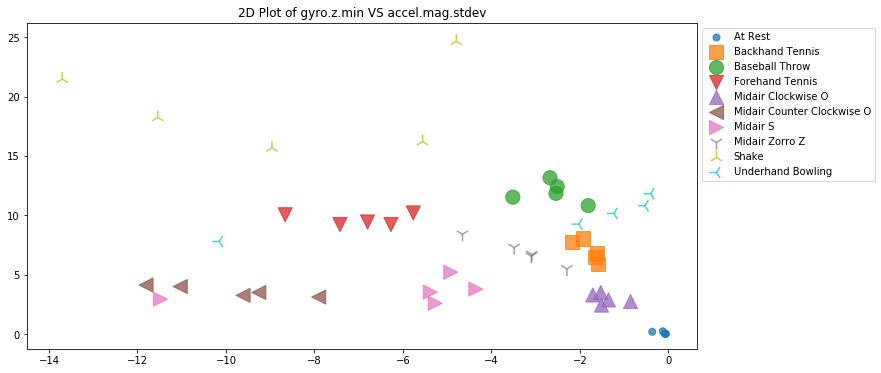

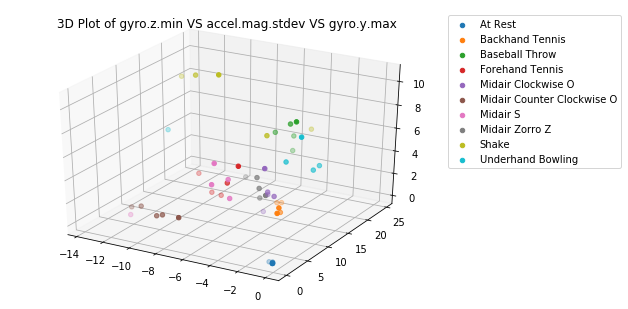

In [154]:
# Using starter code, looked at a variety of features in 1D, 2D, and 3D space

import itertools
import statistics as stats
from mpl_toolkits.mplot3d import Axes3D
import random 

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

# 1D Plot 1
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in profGestureToTrials.items():
    x = list(trial.gyro.z.min() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of gyro.z.min")
plt.show()

# 1D Plot 2
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in profGestureToTrials.items():
    x = list(stats.stdev(trial.accel.mag) for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of accel.mag.stdev")
plt.show()

# 2D Plot 1
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in profGestureToTrials.items():
    x = list(trial.gyro.z.min() for trial in trials)
    y = list(stats.stdev(trial.accel.x) for trial in trials)
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("2D Plot of gyro.z.min VS accel.mag.stdev")
plt.show()

# 3D Plot 1
# implementation found at https://stackoverflow.com/questions/1985856/how-to-make-a-3d-scatter-plot-in-python
fig = plt.figure()
ax = Axes3D(fig)
for gestureName, trials in profGestureToTrials.items():
    x = list(trial.gyro.z.min() for trial in trials)
    y = list(stats.stdev(trial.accel.x) for trial in trials)
    z = list(trial.gyro.y.max() for trial in trials)
    #s = [200] * len(x)
    ax.scatter(x, y, z, label=gestureName)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("3D Plot of gyro.z.min VS accel.mag.stdev VS gyro.y.max")
plt.show()


# Gesture Classification

## My Functions

In [189]:
'''
Professor's pseudo-code for k-fold analysis:
1. Randomly split the data into k-folds (in this case, k=5). Ensure that each gesture is represented in each fold.
2. Select the first fold as your test fold and the remaining folds as your training folds (we should really call them template folds in this case, since we are not really using a supervised learning approach for the mid-point checkin but rather a template- or shape-matching approach).
3. Iterate through each gesture in your test fold and find the closest matching gesture in your template folds. Write bookkeeping code to keep track of the best match + the score (better yet, track the N-best list of matches for each gesture).
4. Now, move on to the second fold and use the other folds as your template folds and repeat. In this case, let's select fold #2 as the test fold and folds #1, 3, 4 and 5 as the template folds.
5. After all folds have been test folds, you should be able to produce a performance list like I displayed for the mid-point checkin (as well as a confusion matrix of results, which is not required for mid-point but is for final A2 deliverable).
'''
def fiveFoldEuclideanDistance(mapGestureToTrials):
    # create empty folds
    folds = [[], [], [], [], []]

    # create dict for tracking correct matches
    scorecard = dict.fromkeys(mapGestureToTrials.keys(), 0)

    # fill folds with one trial from each gesture (randomly)
    for gesture in mapGestureToTrials.keys():
        trials = mapGestureToTrials[gesture]

        # shuffle trial order for each gesture
        random.shuffle(trials)

        # now with random order add to folds
        for i in range(len(folds)):
            folds[i].append(trials[i])
    
    # each fold is the test fold once
    for foldNum in range(len(folds)):        

        # loop over all trials in given test fold
        for i in range(len(folds[foldNum])):
            testTrial = folds[foldNum][i]
            bestMatch = None
            bestMatch2 = None

            # compare trial against all folds
            for currentFold in folds:

                # ignore current fold
                if currentFold == folds[foldNum]:
                    continue

                # compare against trials in current template fold
                for templateTrial in currentFold:
                    smoothTest = filterLowPassSignal(testTrial.accel.mag)
                    smoothTemplate = filterLowPassSignal(templateTrial.accel.mag)
                    testTrialAligned = alignSignals(smoothTest, smoothTemplate)
                    testVsTemplateDistance = distance.euclidean(testTrialAligned, smoothTemplate)
                    returnTuple = (templateTrial.gestureName, templateTrial, testVsTemplateDistance)
                    if bestMatch is None or testVsTemplateDistance < bestMatch[2]:
                        bestMatch = returnTuple
                    
                    # track second best value
                    if bestMatch2 is None or (testVsTemplateDistance < bestMatch2[2] and testVsTemplateDistance > bestMatch[2]):
                        bestMatch2 = returnTuple

            # update scorecard to determine best match or not
            if testTrial.gestureName == bestMatch[0]:
                scorecard[testTrial.gestureName] += 1
            else:
                #print("TOP: {}\tSECOND: {}".format(bestMatch[2], bestMatch2[2]))
                
                # if a close tie at second (within 10%)
                # options: resmooth, look at gyro, look at something else?
                if bestMatch2[2] < (1.25 * bestMatch[2]):
                
                    # filter test trial again
                    smoothTest = filterLowPassSignal(testTrial.gyro.mag)

                    # redo top 
                    topTemplate = bestMatch[1]
                    smoothTopTemplate = filterLowPassSignal(topTemplate.gyro.mag)
                    testTrialAlignedTop = alignSignals(smoothTest, smoothTopTemplate)
                    testVsTop = distance.euclidean(testTrialAlignedTop, smoothTopTemplate)

                    # redo second 
                    secondTemplate = bestMatch2[1]
                    smoothSecondTemplate = filterLowPassSignal(secondTemplate.gyro.mag)
                    testTrialAlignedSecond = alignSignals(smoothTest, smoothSecondTemplate)
                    testVsSecond = distance.euclidean(testTrialAlignedSecond, smoothSecondTemplate)

                    #print("TOP REDONE: {}\tSECOND REDONE: {}".format(testVsTop, testVsSecond))
                    if testVsSecond < testVsTop:
                        if testTrial.gestureName == secondTemplate.gestureName:
                            scorecard[testTrial.gestureName] += 1
            

    printScorecard("Shape-Matching (Euclidean Distance)", scorecard)

def alignSignals(a, b):
    # Now let's use correlation to align the signals before comparison
    correlateAToB = signal.correlate(a,b)
    bestCorrelationPoint = np.argmax(correlateAToB)
    indexShift = len(a) - np.argmax(correlateAToB)
    a_shifted = np.roll(a, indexShift)
    return a_shifted

def filterLowPassSignal(signal, n=3):
    # implementation found on https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    ret = np.cumsum(signal, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation)
fixedFoldsToMapGestureToTrial = None
def generate_kfolds(mapGestureToTrials, numFolds=5, createNewKFold=False):
    global fixedFoldsToMapGestureToTrial
    
    if createNewKFold is False and fixedFoldsToMapGestureToTrial is not None:
        return fixedFoldsToMapGestureToTrial
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in mapGestureToTrials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))


    numGestures = len(mapGestureToTrials)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in mapGestureToTrials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(mapGestureToTrials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    if fixedFoldsToMapGestureToTrial is None:
        fixedFoldsToMapGestureToTrial = foldToMapGestureToTrial
    
    return foldToMapGestureToTrial
   
# takes in the current testFold, the trainingFolds, and a create_feature_vector function
# the create_feature_vector function creates feature vectors given a Trial object
# I suggest creating multiple different create_feature_vector functions that you pass
# in here and test (this will allow you to easily compare different feature vectors)
def get_svm_input(testFold, trainingFolds, create_feature_vector):
    
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    #print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])
  
    # Build up the training data and also keep track of the class labels (in trainingLabels)
    row = 0
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            row = row + 1
    
    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testGestureName)
        testRow = testRow + 1
    
    return (trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials)

# Example create_feature_vector function that returns a 3D feature vector for the given trial        
def create_simple_feature_vector(trial):
    return [trial.gyro.y.max(),
            trial.gyro.z.min(),
            stats.stdev(trial.accel.x)
           ]

def runSVM(mapGestureToTrials):
    # setup variables
    numFolds = get_min_num_of_trials(mapGestureToTrials)
    numGestures = len(mapGestureToTrials)
    numTrials = get_total_num_of_trials(mapGestureToTrials)
    foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials)
    gestureNames = list(mapGestureToTrials.keys())
    scorecard = dict.fromkeys(mapGestureToTrials.keys(), 0)

    for j in range(len(foldToMapGestureToTrial)):
        # This is an example of how you would call the get_svm_input method
        # You'll have to figre out how to appropriately put this in a for loop and use it...  
        testFold = foldToMapGestureToTrial[j]
        trainingFolds = foldToMapGestureToTrial[:j] + foldToMapGestureToTrial[j+1:]
        svmInput = get_svm_input(testFold, trainingFolds, create_simple_feature_vector)

        # Unpack the tuple into more semantic variable names
        trainingData, trainingLabels, trainingTrials, testData, groundtruthLabels, testTrials = svmInput

        ## Training our SVM
        clf = svm.SVC()
        clf.fit(trainingData, trainingLabels) 

        svmPrediction = clf.predict(testData)
        for i in range(len(testData)):
            if svmPrediction[i] == groundtruthLabels[i]:
                scorecard[groundtruthLabels[i]] += 1
            #else:
                #print("XX Truth: {}\tSVM: {}".format(groundtruthLabels[i], svmPrediction[i]))

    printScorecard("{}D SVM".format(len(trainingData[0])),scorecard)
    
def printScorecard(method, scorecard):
    TRIAL_COUNT = 5
    totalRight = sum(scorecard.values())
    totalPossible = TRIAL_COUNT * len(scorecard.keys())
    
    print("{} Overall Accuracy: {}/{} ({::=.1%})".format(method, totalRight, totalPossible, totalRight/totalPossible))
    
    for (gesture, correctCount) in scorecard.items():
        print("{} {}/{} ({::=.1%})".format(gesture, correctCount, TRIAL_COUNT, correctCount/5))
  

## Shape-matching (Euclidean distance)

In [199]:
print("Professor Data")
fiveFoldEuclideanDistance(profGestureToTrials)

print("\nMy Data")
fiveFoldEuclideanDistance(myGestureToTrials)

Professor Data
Shape-Matching (Euclidean Distance) Overall Accuracy: 50/50 (100.0%)
At Rest 5/5 (100.0%)
Backhand Tennis 5/5 (100.0%)
Baseball Throw 5/5 (100.0%)
Forehand Tennis 5/5 (100.0%)
Midair Clockwise O 5/5 (100.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Midair S 5/5 (100.0%)
Midair Zorro Z 5/5 (100.0%)
Shake 5/5 (100.0%)
Underhand Bowling 5/5 (100.0%)

My Data
TOP: 57.441068778532724	SECOND: 62.284713324577936
TOP REDONE: 19.72516935044341	SECOND REDONE: 18.10133781886808
Shape-Matching (Euclidean Distance) Overall Accuracy: 55/55 (100.0%)
At Rest 5/5 (100.0%)
Backhand Tennis 5/5 (100.0%)
Baseball Throw 5/5 (100.0%)
Forehand Tennis 5/5 (100.0%)
Midair Clockwise O 5/5 (100.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Midair S 5/5 (100.0%)
Midair Zorro Z 5/5 (100.0%)
Shake 5/5 (100.0%)
Underhand Bowling 5/5 (100.0%)
Your Custom Gesture 5/5 (100.0%)


## 3-dimensional SVM

In [152]:
print("Professor Data")
runSVM(profGestureToTrials)

print("\nMy Data")
runSVM(myGestureToTrials)

Professor Data
3D SVM Overall Accuracy: 45/50 (90.0%)
At Rest 5/5 (100.0%)
Backhand Tennis 5/5 (100.0%)
Baseball Throw 4/5 (80.0%)
Forehand Tennis 5/5 (100.0%)
Midair Clockwise O 4/5 (80.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Midair S 4/5 (80.0%)
Midair Zorro Z 5/5 (100.0%)
Shake 5/5 (100.0%)
Underhand Bowling 3/5 (60.0%)

My Data
3D SVM Overall Accuracy: 45/55 (81.8%)
At Rest 5/5 (100.0%)
Backhand Tennis 5/5 (100.0%)
Baseball Throw 4/5 (80.0%)
Forehand Tennis 5/5 (100.0%)
Midair Clockwise O 4/5 (80.0%)
Midair Counter Clockwise O 5/5 (100.0%)
Midair S 4/5 (80.0%)
Midair Zorro Z 5/5 (100.0%)
Shake 5/5 (100.0%)
Underhand Bowling 3/5 (60.0%)
Your Custom Gesture 0/5 (0.0%)
